## Imports

In [3]:
import time
import random
import collections
import os
import unityagents       as ua
import numpy             as np
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim

## Settings

In [ ]:
%matplotlib inline
%config Completer.use_jedi = False

## Constants

In [3]:
SEED = 42

## DQN Model

In [5]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size, fc_1_size, fc_2_size):
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(SEED)
        
        self.fc_1 = nn.Linear(state_size, fc_1_size)
        self.fc_2 = nn.Linear( fc_1_size, fc_2_size)
        self.fc_3 = nn.Linear( fc_2_size, action_size)
        
        
    def forward(self, state):
        # First layer
        x = self.fc_1(state)
        x = F.relu(x)
        
        # Second layer
        x = self.fc_2(x)
        x = F.relu(x)
        
        # Third layer (output layer)
        x = self.fc_3(x)
        
        return x

In [6]:
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size, fc_1_size, fc_2_size):
        super(DuelingDQN, self).__init__()
        
        self.seed = torch.manual_seed(SEED)
        
        # First hidden layer
        self.fc_1 = nn.Linear(state_size, fc_1_size)
        
        # Advantage
        self.fc_adv = nn.Linear(fc_1_size, action_size)
        
        # Value
        self.fc_val = nn.Linear(fc_1_size, 1)
        
        
    def forward(self, state):
        # Hidden layer
        x = self.fc_1(state)
        x = F.relu(x)
        
        # Value
        value = self.fc_val(x)
        value = F.relu(value)
        
        # Advantage
        advantage = self.fc_adv(x)
        advantage = F.relu(advantage)
        
        # Output layer
        return value + (advantage - torch.mean(advantage, dim = 1, keepdim = True))

## Replay Buffer

In [7]:
class ReplayBuffer():
    def __init__(self, action_size, batch_size, buffer_size, cuda):
        self.seed = random.seed(SEED)
        self.cuda = cuda
        
        self.action_size = action_size
        self.batch_size  = batch_size
        self.memory      = collections.deque(maxlen = buffer_size)
        
        self.exp = collections.namedtuple(
            typename    = "exp",
            field_names = [
                "state",
                "action",
                "reward",
                "next_state",
                "done"
            ]
        )
        
        
    def add(self, state, action, reward, next_state, done):
        self.memory.append(
            self.exp(state, action, reward, next_state, done)
        )
        
        
    def sample(self):
        exp = random.sample(
            population = self.memory,
            k          = self.batch_size
        )
        
        return(
            torch.FloatTensor(np.vstack([e.state      for e in exp if e is not None])                 ).to(self.cuda), # states
            torch.LongTensor( np.vstack([e.action     for e in exp if e is not None])                 ).to(self.cuda), # actions
            torch.FloatTensor(np.vstack([e.reward     for e in exp if e is not None])                 ).to(self.cuda), # rewards
            torch.FloatTensor(np.vstack([e.next_state for e in exp if e is not None])                 ).to(self.cuda), # next_states
            torch.FloatTensor(np.vstack([e.done       for e in exp if e is not None]).astype(np.uint8)).to(self.cuda)  # dones
        )
    
    
    def __len__(self):
        return len(self.memory)

## Agent

In [8]:
class Agent():
    def __init__(self, action_size, batch_size, buffer_size, gamma, lr, state_size, tau, update_every, fc_1_size, fc_2_size, use_duel, use_double):
        self.seed = random.seed(SEED)

        if torch.cuda.is_available():
            self.device = torch.device("cuda")
            print("[INFO] using CUDA")
            
        else:
            self.device = torch.device("cpu")
            print("[INFO] using CPU")
        
        
        self.action_size  = action_size
        self.batch_size   = batch_size
        self.buffer_size  = buffer_size
        self.gamma        = gamma
        self.lr           = lr
        self.state_size   = state_size
        self.tau          = tau
        self.update_every = update_every
        self.fc_1_size    = fc_1_size
        self.fc_2_size    = fc_2_size
        self.use_duel     = use_duel
        self.use_double   = use_double
        
        
        # Dueling DQN
        # --------------------------------------------------
        if self.use_duel:
            self.local_qnet  = DuelingDQN(self.state_size, self.action_size, self.fc_1_size, self.fc_2_size).to(self.device)
            self.target_qnet = DuelingDQN(self.state_size, self.action_size, self.fc_1_size, self.fc_2_size).to(self.device)
        
        
        # DQN
        # --------------------------------------------------
        else:
            self.local_qnet  = DQN(self.state_size, self.action_size, self.fc_1_size, self.fc_2_size).to(self.device)
            self.target_qnet = DQN(self.state_size, self.action_size, self.fc_1_size, self.fc_2_size).to(self.device)
        
        
        self.optimizer = optim.Adam(
            self.local_qnet.parameters(), 
            lr = self.lr
        )
        
        self.memory = ReplayBuffer(self.action_size, self.batch_size, self.buffer_size, self.device)
        self.t      = 0
        
        
    def act(self, state, eps):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        self.local_qnet.eval()
        
        with torch.no_grad():
            action_values = self.local_qnet(state)
            
        self.local_qnet.train()
        
        if random.random() > eps: return np.argmax(action_values.cpu().data.numpy()).astype('int')
        else:                     return random.choice(np.arange(self.action_size))
        
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t = (self.t + 1) % self.update_every
        
        if self.t == 0 and len(self.memory) > self.batch_size:
            self.learn(self.memory.sample(), self.gamma)
            
            
    def learn(self, exp, gamma):
        states, actions, rewards, next_states, dones = exp
        
        
        # Double Q-Network
        # --------------------------------------------------
        if self.use_double:
            local_qnet_actions = torch.LongTensor(self.local_qnet(next_states).detach().max(1)[1].unsqueeze(1))
            local_qnet_next    = self.target_qnet(next_states).gather(1, local_qnet_actions)
            q_targets          = rewards + (gamma * local_qnet_next * (1 - dones))
            q_expected         = self.local_qnet(states).gather(1, actions)
        
        
        # Default Q-Network
        # --------------------------------------------------
        else:
            q_targets_next = self.target_qnet(next_states).detach().max(1)[0].unsqueeze(1)    
            q_targets      = rewards + (gamma * q_targets_next * (1 - dones))
            q_expected     = self.local_qnet(states).gather(1, actions)
        
        
        loss = F.mse_loss(q_expected, q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        for target_param, local_param in zip(self.target_qnet.parameters(), self.local_qnet.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

## Training

In [9]:
def train(env, n_episodes, max_t, eps_start, eps_end, eps_decay, train_mode = True):
    scores_window = collections.deque(maxlen = 100)  
    eps           = eps_start                  
    scores        = []  
    
    brain_name = env.brain_names[0]
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode = train_mode)[brain_name]
        state    = env_info.vector_observations[0]
        score    = 0
        
        for t in range(max_t):
            action     = agent.act(state, eps)
            env_info   = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward     = env_info.rewards[0]
            done       = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            
            score += reward
            state  = next_state
            
            if done:
                break 
                
        scores_window.append(score)       
        scores.append(score)    
        
        eps = max(eps_end, eps_decay*eps)
        
        if i_episode % 100 == 0:
            print(
                f"==================================================\n"
                f"Episode        {i_episode}\n"
                f"Average Score: {np.round(np.mean(scores_window), 2)}\n"
            )
            
        if np.mean(scores_window) >= 13:                
            print(
                f"==================================================\n"
                f"Environment Solved! {i_episode - 100} Episodes\n"
                f"Average Score:      {np.round(np.mean(scores_window), 2)}\n"
            )
                
            torch.save(agent.local_qnet.state_dict(), os.path.join("checkpoints", "checkpoint.pth"))
                
            break
            
    env.close()
    
    return scores

## Initialize Environment

In [10]:
env = ua.UnityEnvironment(
    file_name = "Banana"
)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [11]:
brain_name = env.brain_names[0]
brain      = env.brains[brain_name]

In [12]:
env_info = env.reset(train_mode = True)[brain_name]

In [13]:
agent = Agent(
    action_size  = brain.vector_action_space_size, 
    batch_size   = 64,
    buffer_size  = 10000, 
    gamma        = 0.99,
    lr           = 0.0001,
    state_size   = len(env_info.vector_observations[0]), 
    tau          = 0.001,
    update_every = 4,
    fc_1_size    = 64,
    fc_2_size    = 64,
    use_duel     = False,
    use_double   = True
)

[INFO] using CPU


## Begin Training

In [14]:
start_time = time.time()

scores = train(
    env        = env,
    n_episodes = 2000, 
    max_t      = 1000, 
    eps_start  = 1.0, 
    eps_end    = 0.01, 
    eps_decay  = 0.995
)

exec_time = round(time.time() - start_time, 3)

print(f"Total Training Time: {exec_time} Seconds")

Episode        100
Average Score: 0.4

Episode        200
Average Score: 4.25

Episode        300
Average Score: 7.56

Episode        400
Average Score: 9.96

Episode        500
Average Score: 11.92

Environment Solved! 459 Episodes
Average Score:      13.01

Total Training Time: 460.587 Seconds


## Plot Results

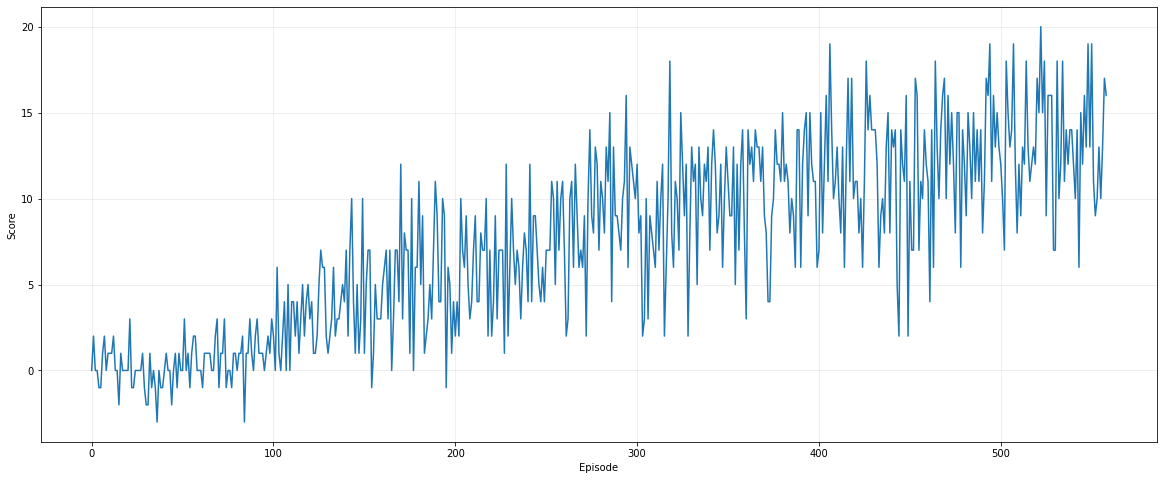

In [15]:
fig = plt.figure(figsize = (20, 8))
ax  = fig.add_subplot(111)

plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')

plt.grid(alpha = 0.25)

plt.show()